# Essential `api` classes

## Introduction
There are a few features within the Shyft `api` that can be helpful for plotting, aggregating, and conducting data reduction. Herein we demonstrate some of this functionality. If you gain an understanding of the aspects described herein, working with Shyft becomes much simpler and more 'pythonic'.


## 0. Loading required python modules and running a configured shyft simulation

The first step below is simply to get a simulation up and running using the features of `orchestration`. If you are not familiar with this step, it is recommended to see the [configured simulation](../nea-example/simulation-configured.ipynb) example first.

In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%pylab inline
import os
import datetime as dt
from os import path
import sys
from matplotlib import pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# try to auto-configure the path, -will work in all cases where doc and data
# are checked out at same level
shyft_data_path = path.abspath("../../../../shyft-data")
if path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
    os.environ['SHYFT_DATA']=shyft_data_path


## 1. The key classes within the `api` and being "pythonic"

There are several essential class types that are used throughout Shyft, and initially, these may cause some challenges -- particularly to seasoned python users. If you are used to working with the `datetime` module, `pandas` and `numpy`, it will be important that you understand some of the basic concepts presented here.

At first, some of this may seem unneccessary. The point of these specialized classes are to provide efficiency withing the C++ core, and with respect to time, to make sure the calculations adhere to a few strict concepts.

### `IntVector`, and other `---Vector` types
When you see the class `IntVector`, just recognize these as lists. They should behave nearly identical to python lists, and where possible, we treat them as such. The main difference, is that they are specialized for their 'type', and under the covers within Shyft provide great efficiency.

In [3]:
from shyft.time_series import IntVector, DoubleVector
import numpy as np
# works:
iv = IntVector([0, 1, 4, 5])
print(iv)
# won't work:
# iv[2] = 2.2

# see the DoubleVector
dv = DoubleVector([1.0, 3, 4.5, 10.110293])
print(dv)
dv[0] = 2.3


[0 1 4 5]
[ 1.        3.        4.5      10.110293]


Note, however, that these containers are very basic lists. They don't have methods such as `.pop` and `.index`. In generally, they are meant just to be used as first class containers for which you'll pass data into before passing it to Shyft. For those familiar with python and numpy, you can think of it similar to the advantages of using numpy arrays over pure python lists. The numpy array is far more efficient. In the case of Shyft, it is similar, and the `IntVector`, `DoubleVector` and other specialized vector types are much more efficient.


In [4]:
IV1 = IntVector([int(i) for i in np.arange(1000)])


In [9]:
# once the shyft_path is set correctly, you should be able to import shyft modules
import shyft

# if you have problems here, it may be related to having your LD_LIBRARY_PATH
# pointing to the appropriate libboost_python libraries (.so files)
from shyft import hydrology
from shyft.hydrology import shyftdata_dir
from shyft.hydrology.repository.default_state_repository import DefaultStateRepository
from shyft.hydrology.orchestration.configuration.yaml_configs import YAMLSimConfig
from shyft.hydrology.orchestration.simulators.config_simulator import ConfigSimulator

In [10]:
# here is the *.yaml file that configures the simulation:
config_file_path = os.path.abspath("../nea-example/nea-config/neanidelva_simulation.yaml")
config_file_path = os.path.join(shyftdata_dir,"neanidelv/yaml_config/neanidelva_simulation.yaml")
# or alternative, if you set path manually:
# config_file_path = os.path.join(shyft_data_path,"neanidelv/yaml_config/neanidelva_simulation.yaml")

cfg = YAMLSimConfig(config_file_path, "neanidelva")

simulator = ConfigSimulator(cfg) 
# run the model, and we'll just pull the `api.model` from the `simulator`
simulator.run()
model = simulator.region_model

Running simulation...


## 1. `shyft.time_series.TimeSeries`

The Shyft time_series, `shyft.time_series` contains a lot of functionality worth exploring.

The `TimeSeries` class provides some tools for adding timeseries, looking at statistics, etc. Below is a quick exploration of some of the possibilities. Users should explore using the source code, tab completion, and most of all `help` to get the full story...

Text(0, 0.5, 'discharge [m3 s-1]')

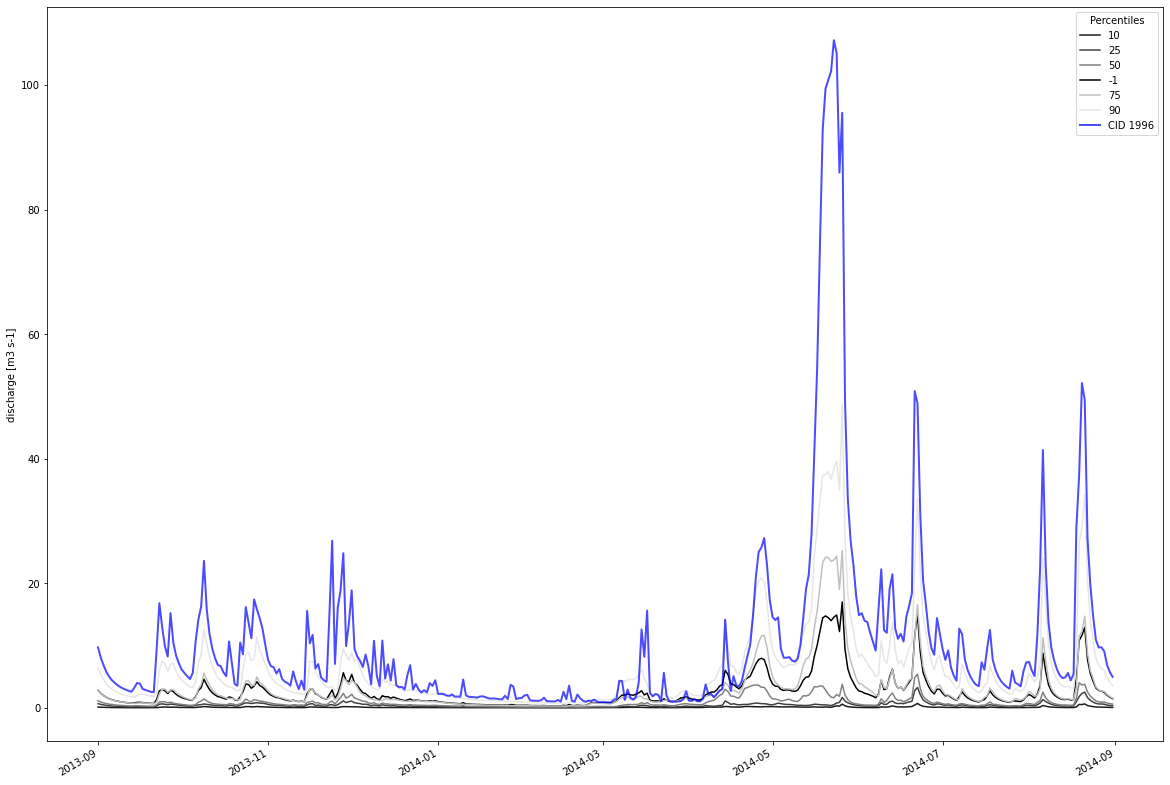

In [11]:
# First, we can also plot the statistical distribution of the 
# discharges over the sub-catchments
from shyft.time_series import TsVector,IntVector,TimeAxis,Calendar,time,UtcPeriod
# api.TsVector() is a a strongly typed list of time-series,that supports time-series vector operations. 
discharge_ts = TsVector() #  except from the type, it just works as a list()
# loop over each catchment, and extract the time-series (we keep them as such for now)
for cid in model.catchment_ids: # fill in discharge time series for all subcatchments
    discharge_ts.append(model.statistics.discharge([int(cid)]))

# get the percentiles we want, note -1 = arithmetic average
percentiles= IntVector([10,25,50,-1,75,90])  

# create a Daily(for the fun of it!) time-axis for the percentile calculations
# (our simulation could be hourly) 
ta_statistics = TimeAxis(model.time_axis.time(0), Calendar.DAY, 365)

# then simply get out a new set of time-series, corresponding to the percentiles we specified
# note that discharge_ts is of the TsVector type, not a simple list as in our first example above
discharge_percentiles = discharge_ts.percentiles(ta_statistics, percentiles)

#utilize that we know that all the percentile time-series share a common time-axis
ts_timestamps = [dt.datetime.utcfromtimestamp(int(p.start)) for p in ta_statistics] 

# Then we can make another plot of the percentile data for the sub-catchments
fig, ax = plt.subplots(figsize=(20,15))

# plot each discharge percentile in the discharge_percentiles
for i,ts_percentile in enumerate(discharge_percentiles):
    clr='k'
    if percentiles[i] >= 0.0: 
        clr= str(float(percentiles[i]/100.0))
    ax.plot(ts_timestamps, ts_percentile.values, label = "{}".format(percentiles[i]), color=clr)

# also plot catchment discharge along with the statistics
# notice that we use .average(ta_statistics) to properly align true-average values to time-axis
ax.plot(ts_timestamps, discharge_ts[0].average(ta_statistics).values, 
        label = "CID {}".format(model.catchment_ids[0]),
        linewidth=2.0, alpha=0.7, color='b')

fig.autofmt_xdate()
ax.legend(title="Percentiles")
ax.set_ylabel("discharge [m3 s-1]")

Text(0.5, 1.0, 'CID 1996')

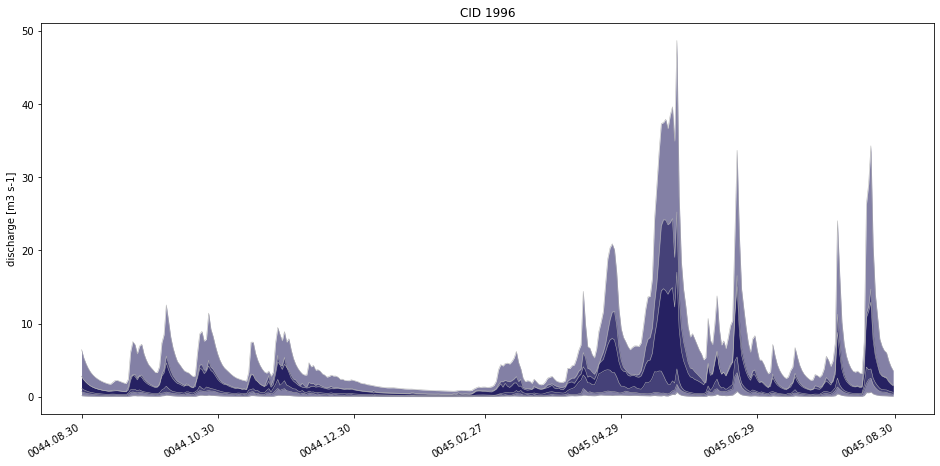

In [12]:
# a simple percentile plot, from orchestration looks nicer
from shyft.hydrology.orchestration import plotting as splt
oslo = Calendar('Europe/Oslo')
fig, ax = plt.subplots(figsize=(16,8))
splt.set_calendar_formatter(oslo)
h, ph = splt.plot_np_percentiles(ts_timestamps,[ p.values for p in discharge_percentiles],
                                base_color=(0.03,0.01,0.3))

ax = plt.gca()
ax.set_ylabel("discharge [m3 s-1]")                                 
plt.title("CID {}".format(model.catchment_ids[0]))